In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
from os.path import exists
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import compress
from pylab import MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio import Phylo

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
from collections import Counter

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# [A] SNVS ACROSS THE GENOME

# [1] *Functions* to get mutation events from branches given a tree

In [3]:
def num_mutations_on_branch_SNV(branch_length_i, num_sites_to_construct_tree):
    
    '''
    This function takes a branch length as INPUT and OUTPUTs
    (1) the number of neutral mutations that occur on this branch length 
    by drawing from a poisson distribution and (2) a list of the chromosomal
    positions that are mutated (drawn randomly from across the chromosome).
    '''
    
    # get molecular clock rate (mu_i) to convert branch length into years
    mu_i = np.random.uniform(low=0.3, high=0.6)

    # get t_i, the branch length in years
    t_i = (branch_length_i * num_sites_to_construct_tree) / mu_i

    # get the mutation rate for neutral mutations (nu_i) to calculate lambda
    nu_i = np.random.uniform(low=0.3, high=0.6)

    # calculate lambda, parameter for poisson distribution
    lambda_i = t_i * nu_i

    # draw from poisson distribution to get the number of neutral mutations that occurred on this branch
    num_mutations_i = np.random.poisson(lam=lambda_i)
    
    # choose number drawn above positions from range(0, length of chrom) that were "mutated", choose the H37Rv ref positions that mutated randomly
    positions_mutated_i = np.random.randint(low=1, high=chrom_length+1, size=num_mutations_i)
    
    return [num_mutations_i, positions_mutated_i]

In [4]:
def get_mutation_events_from_tree_branches(num_sites_to_construct_tree, isolate_group):

    # Load in PHYLOGENY
    #########################################################################################################
    # We're going to use Biopython's Phylo module to load phylogenetic trees created by Luca
    
    phylogeny_path = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/phylogenies/tree_output_files/phylogeny_lineage_' + isolate_group + '/tree_lineage_' + isolate_group + '_iqtree_FINAL.treefile'

    # parses and load tree
    tree = Phylo.parse(phylogeny_path , 'newick').next() 

    # root the tree with the outgroup M. canettii ["Normally you will want the outgroup to be a monophyletic group, rather than a single taxon."]
    tree.root_with_outgroup({"name":"canettii"})

    # flip branches so deeper clades are displayed at top
    tree.ladderize()

    # TERMINAL BRANCHES
    #########################################################################################################
    # retrieves the terminal nodes of the tree
    terminal_nodes = tree.get_terminals()

    # Lengths of terminal branches
    terminal_branch_length_list = [terminal_nodes[i].branch_length for i in range(0 , len(terminal_nodes))][1:]

    # retrieve Sample IDs that were used for this tree
    isolate_tags_in_phylogeny = [terminal_nodes[i].name for i in range(0 , len(terminal_nodes))]

    # iterate through each branch-length & collect
    # (1) number of neutral mutations on each branch
    # (2) the chromosomal positions of the mutations 
    num_mutations_per_terminal_branch_list = []
    mutation_positions_across_terminal_branches_list = []

    for branch_length_i in terminal_branch_length_list:

        num_mutations_per_branch_i, mutation_positions_per_branch_i = num_mutations_on_branch_SNV(branch_length_i, num_sites_to_construct_tree)

        num_mutations_per_terminal_branch_list.append(num_mutations_per_branch_i)

        mutation_positions_across_terminal_branches_list = mutation_positions_across_terminal_branches_list + list(mutation_positions_per_branch_i)

    # series for number of mutations occurring for each branch
    tree_branch_index = [ isolate_group + '_T_' + str(i) for i in range(1, len(num_mutations_per_terminal_branch_list)+1)]
    num_mutations_per_terminal_branch_series = pd.Series(num_mutations_per_terminal_branch_list, index = tree_branch_index)

    # Counter dict for the number of times each chromosomal position is mutated
    mutation_events_per_pos_from_terminal_dict = Counter(mutation_positions_across_terminal_branches_list)

    # INTERNAL BRANCHES
    #########################################################################################################
    # retrieves the internal nodes of the tree
    internal_nodes = tree.get_nonterminals() 

    # Lengths of internal branches
    internal_branch_length_list = [internal_nodes[i].branch_length for i in range(0 , len(internal_nodes))][2:]

    # iterate through each branch-length & collect
    # (1) number of neutral mutations on each branch
    # (2) the chromosomal positions of the mutations 
    num_mutations_per_internal_branch_list = []
    mutation_positions_across_internal_branches_list = []

    for branch_length_i in internal_branch_length_list:

        num_mutations_per_branch_i, mutation_positions_per_branch_i = num_mutations_on_branch_SNV(branch_length_i, num_sites_to_construct_tree)

        num_mutations_per_internal_branch_list.append(num_mutations_per_branch_i)

        mutation_positions_across_internal_branches_list = mutation_positions_across_internal_branches_list + list(mutation_positions_per_branch_i)

    # series for number of mutations occurring for each branch
    tree_branch_index = [ isolate_group + '_I_' + str(i) for i in range(1, len(num_mutations_per_internal_branch_list)+1)]
    num_mutations_per_internal_branch_series = pd.Series(num_mutations_per_internal_branch_list, index = tree_branch_index)

    # Counter dict for the number of times each chromosomal position is mutated
    mutation_events_per_pos_from_internal_dict = Counter(mutation_positions_across_internal_branches_list)

    # ALL BRANCHES
    #########################################################################################################
    num_mutations_per_branch_series = pd.concat([num_mutations_per_terminal_branch_series, num_mutations_per_internal_branch_series])
    mutation_events_per_pos_dict = mutation_events_per_pos_from_terminal_dict + mutation_events_per_pos_from_internal_dict
    
    return [num_mutations_per_branch_series, mutation_events_per_pos_dict]

# [2] SNVs on genome (*just for testing*)

## [2.1] Simulate mutation events for each tree and aggregate across trees

In [5]:
isolate_group_list = ['1','2','3','4A','4B','4C','5','6']

# sites used to construct each tree
num_sites_to_construct_tree_dict = {'1':243940.0, '2':243542.0, '3':188741.0, '4A':213804.0, '4B':207271.0, '4C':203590.0, '5':33818.0, '6':36923.0}

# length of chromosome
chrom_length = 4000000

num_mutations_per_branch_series_each_tree_list = []
mutation_events_per_pos_dict = Counter()

for isolate_group_i in isolate_group_list:

    num_mutations_per_branch_series_i, mutation_events_per_pos_dict_i = get_mutation_events_from_tree_branches(num_sites_to_construct_tree_dict[isolate_group_i], isolate_group_i)
    
    num_mutations_per_branch_series_each_tree_list.append(num_mutations_per_branch_series_i)
    mutation_events_per_pos_dict = mutation_events_per_pos_dict + mutation_events_per_pos_dict_i
    
# concatenate series that holds num of neutral mutations per branch together across all trees
num_mutations_per_branch_series =  pd.concat(num_mutations_per_branch_series_each_tree_list)

### Distribution of *Number of Neutral Mutations* per branch

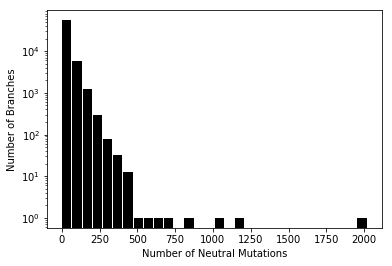

In [6]:
fig, ax = plt.subplots()
ax.hist(num_mutations_per_branch_series, bins = 30, rwidth = 0.9, color = 'k')
plt.xlabel('Number of Neutral Mutations')
plt.ylabel('Number of Branches')
ax.set_yscale('log')
plt.show()

### Distribution of *Number of Mutation Events* (Homoplasy Score) for each Mutant Allele

In [7]:
mutation_events_per_pos_series = pd.Series(mutation_events_per_pos_dict)
mutation_events_per_pos_series.sort_values(ascending = False, inplace = True)
mutation_events_per_pos_series.head(n = 10)

382233     7
108216     6
1636020    6
2444741    6
701732     6
1368553    6
3267951    6
3434720    6
46496      6
585518     6
dtype: int64

In [8]:
homoplasy_score_per_mutation = pd.Series(Counter(mutation_events_per_pos_series))
homoplasy_score_per_mutation

1    1121448
2     240820
3      34878
4       3603
5        294
6         26
7          1
dtype: int64

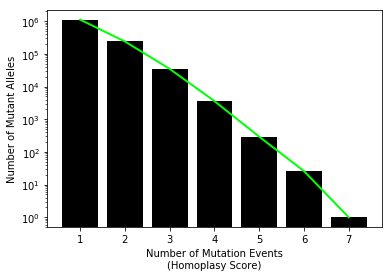

In [9]:
fig, ax = plt.subplots()
ax.hist(mutation_events_per_pos_series, bins = range(1, max(mutation_events_per_pos_series)+2), rwidth = 0.8, align='left', color = 'k')
homoplasy_score_per_mutation = pd.Series(Counter(mutation_events_per_pos_series))
plt.plot(homoplasy_score_per_mutation.index, homoplasy_score_per_mutation.values, color = 'xkcd:bright green', linewidth = 2.0)
plt.xlabel('Number of Mutation Events\n(Homoplasy Score)')
plt.ylabel('Number of Mutant Alleles')
ax.set_yscale('log')
plt.show()

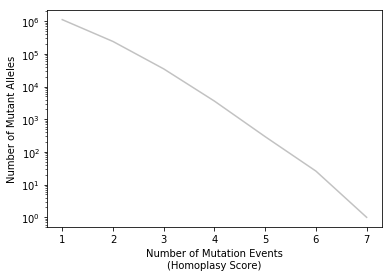

In [10]:
fig, ax = plt.subplots()
plt.plot(homoplasy_score_per_mutation.index, homoplasy_score_per_mutation.values, color = '0.7', alpha = 0.8)
plt.xlabel('Number of Mutation Events\n(Homoplasy Score)')
plt.ylabel('Number of Mutant Alleles')
ax.set_yscale('log')
plt.show()

## [3] Re-run simulation N times

In [14]:
num_sims = 100
homoplasy_score_distribution_per_run = {}
for sim_i in range(1, num_sims+1):

    mutation_events_per_pos_dict = Counter()

    for isolate_group_i in isolate_group_list:

        num_mutations_per_branch_series_i, mutation_events_per_pos_dict_i = get_mutation_events_from_tree_branches(num_sites_to_construct_tree_dict[isolate_group_i], isolate_group_i)
        mutation_events_per_pos_dict = mutation_events_per_pos_dict + mutation_events_per_pos_dict_i

    # distribution of homoplasy score across all mutant alleles
    mutation_events_per_pos_series = pd.Series(mutation_events_per_pos_dict)
    homoplasy_score_per_mutation = pd.Series(Counter(mutation_events_per_pos_series))

    # store distribution of homoplasy scores in dict
    homoplasy_score_distribution_per_run['sim_' + str(sim_i)] = homoplasy_score_per_mutation

### Save results of simulations

In [17]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/SNV_homoplasy_score_distribution_simluation_counts.pickle', 'wb') as handle:
    pickle.dump(homoplasy_score_distribution_per_run, handle, protocol=pickle.HIGHEST_PROTOCOL)

To load dictionary of **homoplasy score** counts for each simulation

In [4]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/SNV_homoplasy_score_distribution_simluation_counts.pickle', 'rb') as handle:
    homoplasy_score_distribution_per_run = pickle.load(handle)

### Plot Homoplasy Score distribution from each simulation

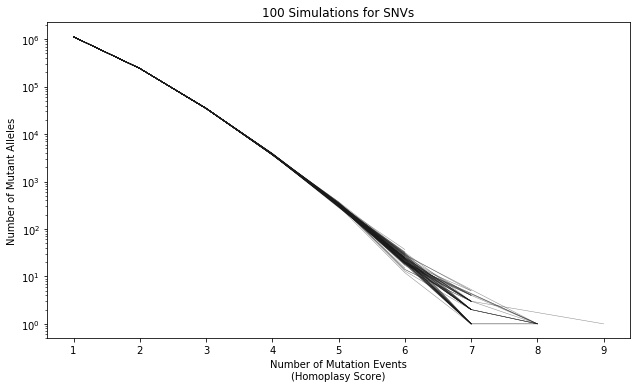

In [5]:
fig, ax = plt.subplots()
for sim_i in homoplasy_score_distribution_per_run.keys():

    plt.plot(homoplasy_score_distribution_per_run[sim_i].index, homoplasy_score_distribution_per_run[sim_i].values, color = '0.1', alpha = 0.5, linewidth = 0.5)

plt.xlabel('Number of Mutation Events\n(Homoplasy Score)')
plt.ylabel('Number of Mutant Alleles')
plt.title('100 Simulations for SNVs')
ax.set_yscale('log')
fig = plt.gcf()
fig.set_size_inches(9.0, 5.5)
fig.tight_layout()
plt.show()

### *Functions* for Boxplot

In [6]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 1.5

# function for setting the colors of the box plots pairs
def setBoxColors(bp , color):
    setp(bp['boxes'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['fliers'][0], color=color)
    setp(bp['medians'][0], color='k' , linewidth = 1.5)
    bp['fliers'][0].set_markerfacecolor('black')
    bp['fliers'][0].set_markeredgewidth(0.35)
    bp['fliers'][0].set_markersize(3.65)
    bp['fliers'][0].set_markeredgecolor('white')
    bp['fliers'][0].set_alpha(0.85)
    
def plot_prop_muts_GE_homoplasy_score(sim_prop_values, x_pos, ax):
    
    #make boxplot
    bp = ax.boxplot(sim_prop_values , positions = [ind[x_pos]], widths = box_width)
    setBoxColors(bp , 'k')
    
    return round(np.median(sim_prop_values), 4)

### Plot cumulative proportion of mutations with homoplasy score $\ge x$ (boxplot)

In [7]:
proportion_greater_than_x_dict = {}

#iterate through homoplasy score cut-off
for x in np.arange(1, 10):

    proportion_homoplasy_scores_greater_than_x_for_each_sim = []
    #iterate through each simulation
    for sim_i in homoplasy_score_distribution_per_run.keys():
    
        proportion_homoplasy_scores_greater_than_x_for_each_sim.append(float((homoplasy_score_distribution_per_run[sim_i][homoplasy_score_distribution_per_run[sim_i].index >= x].sum())) / float((homoplasy_score_distribution_per_run[sim_i].sum())))
        
    proportion_greater_than_x_dict[x] = proportion_homoplasy_scores_greater_than_x_for_each_sim 

/home/rv76/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


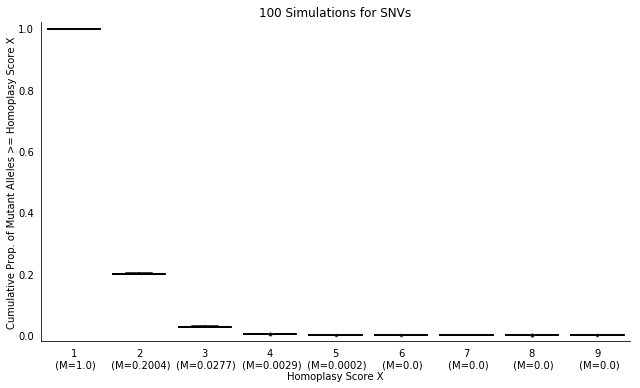

In [8]:
fig , ax = plt.subplots()
box_width = 0.8
ind = np.arange(1, 10)

#bottom plot
median_props = []
x_pos = 0
for homoplasy_score_i in ind:

    #plot boxplot for lineage & store the number of isolates in sample
    median_prop_i = plot_prop_muts_GE_homoplasy_score(proportion_greater_than_x_dict[homoplasy_score_i] , x_pos, ax)
    median_props.append(median_prop_i)
    x_pos += 1

ax.set_xlim(0.5 , 9.5) #x-axis
ax.set_ylim(-0.02 , 1.02) #y-axis
#ax.set_yscale('log')

ax.set_xticks(ind)
ax.set_xticklabels([], rotation='horizontal', fontsize = 10)
x_labels = [str(homoplasy_score_i) + '\n (M=' + str(med_prop) + ')' for homoplasy_score_i,med_prop in zip(ind,median_props)]
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 10)
ax.grid(False)
ax.set_ylabel('Cumulative Prop. of Mutant Alleles >= Homoplasy Score X', fontsize = 10, color = 'k', labelpad = 1)
ax.set_xlabel('Homoplasy Score X', fontsize = 10, color = 'k', labelpad = 1)
ax.set_title('100 Simulations for SNVs')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax.tick_params(colors = 'k', which = 'both')

fig = plt.gcf()
fig.set_size_inches(9.0, 5.5)
fig.tight_layout()
plt.show()

# [B] FRAMESHIFTS IN HOMOPOLYMERIC TRACTS

# [1] *Functions* to get mutation events from branches given a tree

In [3]:
def num_mutations_on_branch_frameshift_HT(branch_length_i, num_sites_to_construct_tree):
    
    '''
    This function takes a branch length as INPUT and OUTPUTs the number of neutral mutations that occur on this branch length,
    in a homopolymeric tract (HT) by drawing from a poisson distribution.
    '''
    
    # get molecular clock rate (mu_i) to convert branch length into years
    mu_i = np.random.uniform(low=0.3, high=0.6)

    # get t_i, the branch length in years
    t_i = (branch_length_i * num_sites_to_construct_tree) / mu_i

    # get the mutation rate for neutral mutations (nu_i) to calculate lambda
    # pull from an exponential distribution (with mean = 10hrs) to "add" to the generation time
    generation_time_buffer = np.random.exponential(scale = 10)
    
    # use time buffer to get the number of generations per day
    num_generations_per_day = 24.0/(24.0+generation_time_buffer)
    
    # based on old fluctuation analysis calculations
    #lower_bound_mut_rate = (1.6e-7)*365*0.74*num_generations_per_day
    #upper_bound_mut_rate = (4.49e-7)*365*0.74*num_generations_per_day
    
    lower_bound_mut_rate = (2.18e-8)*365*num_generations_per_day
    upper_bound_mut_rate = (4.09e-8)*365*num_generations_per_day
    
    nu_i = np.random.uniform(low=lower_bound_mut_rate, high=upper_bound_mut_rate)

    # calculate lambda, parameter for poisson distribution
    lambda_i = t_i * nu_i

    # draw from poisson distribution to get the number of neutral mutations that occurred on this branch
    num_mutations_i = np.random.poisson(lam=lambda_i)
    
    # decide the sign of the mutations (+ for ins, - for del) from bernoulli trial
    trial_for_sign = np.random.binomial(1, 0.5)
    if trial_for_sign == 1:
        sign_mult = 1
    elif trial_for_sign == 0:
        sign_mult = -1
    
    # determine if insertion or deletion with sign
    num_mutations_i = num_mutations_i * sign_mult
    
    return num_mutations_i

In [4]:
def terminal_node_frameshifted_in_HT(terminal_node_i, branch_ID_num_mutations_dict, tree):
    
    '''
    This function takes a terminal node (isolate) label as INPUT, retrieves the branch lengths for 
    the path corresponding between the terminal node & root, retreives the number of frameshift mutations
    that were simulated to occur in each branch in this path and returns the sum of all frameshift mutations that occur along
    this path. It OUTPUTs the number of mutations that occured in the path between root & terminal node.
    '''

    # get the clades between root & terminal node - use 'get_path' method
    # List the clades directly between the tree root (or current clade) and the given target.
    # Returns a list of all clade objects along this path, ending with the given target, but excluding the root clade.
    clade_list_path_btwn_root_terminal_i = tree.get_path(terminal_node_i)

    # get the branch IDs for the path branches between root & terminal node
    # skip first clade (start from 1) because first branch is the MTB MRCA to the Root (M. canettii)
    branch_ID_list_path_btwn_root_terminal_i = [clade_list_path_btwn_root_terminal_i[i].name for i in range(1 , len(clade_list_path_btwn_root_terminal_i))]

    # get number of mutations that occur in HT on each branch in path between root & terminal node (from mutations already assigned to each branch)
    num_mutations_vector_path_btwn_root_terminal_i = np.array([branch_ID_num_mutations_dict[branch_i] for branch_i in branch_ID_list_path_btwn_root_terminal_i])

    # get the sum of all mutations that occur in HT along path between root & terminal node
    num_mutations_path_btwn_root_terminal_i = num_mutations_vector_path_btwn_root_terminal_i.sum()

    return num_mutations_path_btwn_root_terminal_i

In [5]:
def simulate_INDEL_genotypes_at_tips(isolate_group, num_sites_to_construct_tree):

    '''
    This function loads a phylogeny, retrieves the ID and length of each (internal & terminal) branch in the tree
    and simulates a number of frameshift mutations that occurred for each branch in a homopolymeric tract (HT). 
    Then assigns each terminal node a 1 if frameshifted and 0 if not frameshifted depending on the number of 
    mutations in the path between each tip & root. OUTPUT: (1) boolean vector of 0's and 1's corresponding to simulated 
    genotypes for tips of tree and (2) the number of mutations that occurred along each path.
    '''

    # LOAD IN PHYLOGENY
    #########################################################################################################
    # We're going to use Biopython's Phylo module to load phylogenetic trees created by Luca

    phylogeny_path = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/SNP_ancestral_reconstruction/lineage' + isolate_group + '/SNPPar_output/L' + isolate_group + 'node_labelled_newick.tre'

    # parses and load tree
    tree = Phylo.parse(phylogeny_path , 'newick').next() 

    # root the tree with the outgroup M. canettii ["Normally you will want the outgroup to be a monophyletic group, rather than a single taxon."]
    tree.root_with_outgroup({"name":"canettii"})

    # flip branches so deeper clades are displayed at top
    tree.ladderize()

    # TERMINAL BRANCHES
    #########################################################################################################
    # retrieves the terminal nodes of the tree
    terminal_nodes = tree.get_terminals()

    # retrieve Sample IDs that were used for this tree, skip first isolate (start from 1) because first isolate is the Root (M. canettii)
    isolate_tags_in_phylogeny = [terminal_nodes[i].name for i in range(1 , len(terminal_nodes))]

    # Lengths of terminal branches
    terminal_branch_length_list = [terminal_nodes[i].branch_length for i in range(0 , len(terminal_nodes))][1:]

    # Isolate IDs for terminal branches
    terminal_branch_ID_list = [terminal_nodes[i].name for i in range(0 , len(terminal_nodes))][1:]

    # LOAD & FILTER INDEL ANNOTATION
    #########################################################################################################
    #load isolate annotation file (columns of Genotype Matrix)
    isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

    # Find the intersection of isolate tags from Phylogeny & Genotypes Matrix
    isolate_tags_to_keep = list( set(isolate_annotation_DF.isolate_ID).intersection( set(isolate_tags_in_phylogeny) ) )

    # Subset terminal branches from phylogeny to those included in genotype matrix
    isolate_tags_in_phylogeny_and_matrix_ordered = [isolate_tag for isolate_tag in isolate_tags_in_phylogeny if isolate_tag in isolate_tags_to_keep]

    # Subset isolate annotation to only those isolates that are included in phylogeny
    isolates_to_keep_filter = [isolate_tag in isolate_tags_to_keep for isolate_tag in isolate_annotation_DF.isolate_ID]

    # filter isolate annotation df
    isolate_annotation_DF = isolate_annotation_DF[isolates_to_keep_filter]
    isolate_annotation_DF.reset_index(drop = True , inplace = True)

    # Re-order the isolates according to the order of the terminal branches of the phylogeny
    terminal_branch_isolate_order = []

    for isolate_ID in isolate_tags_in_phylogeny_and_matrix_ordered:

        isolate_ID_index = isolate_annotation_DF[isolate_annotation_DF.isolate_ID == isolate_ID].index[0]
        terminal_branch_isolate_order.append(isolate_ID_index)

    # Re-order the rows of the Isolate Annotation DF
    isolate_annotation_DF = isolate_annotation_DF.iloc[terminal_branch_isolate_order , :]

    #reset the index
    isolate_annotation_DF.reset_index(inplace = True, drop = True)

    # INTERNAL BRANCHES
    #########################################################################################################
    # retrieves the internal nodes of the tree
    internal_nodes = tree.get_nonterminals() 

    # Lengths of internal branches
    internal_branch_length_list = [internal_nodes[i].branch_length for i in range(0 , len(internal_nodes))][2:]

    # Isolate IDs for internal branches
    internal_branch_ID_list = [internal_nodes[i].name for i in range(0 , len(internal_nodes))][2:]

    # AGGREGATE BRANCH LENGTHS TOGETHER ALONG WITH IDS
    #########################################################################################################
    branch_ID_list = terminal_branch_ID_list + internal_branch_ID_list # keys of dictionary
    branch_length_list = terminal_branch_length_list + internal_branch_length_list #values of dictionary

    branch_ID_length_dict = dict(zip(branch_ID_list, branch_length_list))

    # SIMULATE A NUMBER OF FRAMESHIFTS ON EACH BRANCH
    #########################################################################################################
    branch_num_sim_mutations_list = []
    for branch_i in branch_ID_length_dict.keys():
        branch_num_sim_mutations_list.append(num_mutations_on_branch_frameshift_HT(branch_ID_length_dict[branch_i], num_sites_to_construct_tree))

    branch_ID_num_mutations_dict = dict(zip(branch_ID_list, branch_num_sim_mutations_list))

    # USE PATHS BETWEEN ROOT & TERMINAL NODES TO DETERMINE WHETHER EACH TERMINAL HAS FRAMESHIFT IN HT
    #########################################################################################################
    num_mutations_root_terminal_paths = [] # this list holds the number of frameshifts that occur along each terminal/root path also the genotypes of the variant found at the tips

    for terminal_node_i in isolate_tags_in_phylogeny:

        num_mutations_root_terminal_path_i = terminal_node_frameshifted_in_HT(terminal_node_i, branch_ID_num_mutations_dict, tree)
        num_mutations_root_terminal_paths.append(num_mutations_root_terminal_path_i)

    # convert list to arrays
    num_mutations_root_terminal_paths = np.array(num_mutations_root_terminal_paths)

    return [num_mutations_root_terminal_paths, isolate_annotation_DF, tree]

In [6]:
def calc_homoplasy_score_for_INDEL(isolate_annotation_DF, INDEL_i_genotypes, spacer_length, tree, INDEL_i_minor_allele):
    
    '''
    INPUT: (1) filtered isolate annotation DF for a specific tree
           (2) simulated genotypes for frameshift INDEL - vector of 0's and 1's
           (3) # length of spacer to define 'blocks' of allele types
           (4) INDEL i minor allele (+1, +2, +3, ...)
    This function calculates a homoplasy score using TopDis method.
    ''' 
    
    INDEL_i_major_allele = 0

    #> Find all the subsets of continuous minor alleles within the terminal brances (including 9's)
    #> Create a boolean array that is *True* if INDEL_i was called as the minor allele or missing data for the isolate, and *False* if INDEL_i was called at the major allele
    INDEL_i_genotypes_bool = INDEL_i_genotypes != INDEL_i_major_allele

    #> Return the indices of the array where the elements are marked *True*
    INDEL_i_genotypes_indices_with_minor_allele = np.arange(0 , len(INDEL_i_genotypes_bool))[INDEL_i_genotypes_bool]

    #1. run through the indices of the isolates with the minor allele
    #2. for each consective *block* of isolates with the minor allele store the isolate ID indices in a seperate list
    #3. pull the genotypes from the indices and make sure there is at least a single isolate with the minor allele (it's not all just 9's)
    #4. for each block of Isolate indices, retrieve isolate IDs from annotation DF
    
    ########################################################################################################################
    isolate_blocks_with_minor_allele = []

    #if consecutive isolates with minor allele have at least (spacer_length) isolates with major allele (or other minor allele) between them
    isolate_block_w_minor_allele_indices = []
    for i in np.arange(0 , len(INDEL_i_genotypes_indices_with_minor_allele)-1):

        space_btwn_genotype_indices = INDEL_i_genotypes_indices_with_minor_allele[i+1] - INDEL_i_genotypes_indices_with_minor_allele[i]
        if space_btwn_genotype_indices <= spacer_length:

            isolate_block_w_minor_allele_indices.append(INDEL_i_genotypes_indices_with_minor_allele[i])

            #check if second to last index
            if i+1 == (len(INDEL_i_genotypes_indices_with_minor_allele)-1):

                isolate_block_w_minor_allele_indices.append(INDEL_i_genotypes_indices_with_minor_allele[i+1])

                #######################################################
                #INDEL genotypes for isolates
                isolate_block_genotypes = INDEL_i_genotypes[isolate_block_w_minor_allele_indices]

                #check to see that at least 1 isolate had a good call for the minor allele within the block
                if INDEL_i_minor_allele in isolate_block_genotypes:

                    #pull the isolate IDs for each index
                    isolate_block_w_minor_allele_IDs = [{'name':isolate_annotation_DF.loc[isolate_index , 'isolate_ID']} for isolate_index in isolate_block_w_minor_allele_indices]

                    #append to list of blocks of isolates w/ minor allele
                    isolate_blocks_with_minor_allele.append(isolate_block_w_minor_allele_IDs)
                #######################################################

        elif space_btwn_genotype_indices > spacer_length:

            isolate_block_w_minor_allele_indices.append(INDEL_i_genotypes_indices_with_minor_allele[i])

            #######################################################
            #INDEL genotypes for isolates
            isolate_block_genotypes = INDEL_i_genotypes[isolate_block_w_minor_allele_indices]

            #check to see that at least 1 isolate had a good call for the minor allele within the block
            if INDEL_i_minor_allele in isolate_block_genotypes:

                #pull the isolate IDs for each index
                isolate_block_w_minor_allele_IDs = [{'name':isolate_annotation_DF.loc[isolate_index , 'isolate_ID']} for isolate_index in isolate_block_w_minor_allele_indices]

                #append to list of blocks of isolates w/ minor allele
                isolate_blocks_with_minor_allele.append(isolate_block_w_minor_allele_IDs)
            #######################################################

            isolate_block_w_minor_allele_indices = []

            #check if second to last index
            if i+1 == (len(INDEL_i_genotypes_indices_with_minor_allele)-1):

                isolate_block_w_minor_allele_indices.append(INDEL_i_genotypes_indices_with_minor_allele[i+1])

                #######################################################
                #INDEL genotypes for isolates
                isolate_block_genotypes = INDEL_i_genotypes[isolate_block_w_minor_allele_indices]

                #check to see that at least 1 isolate had a good call for the minor allele within the block
                if INDEL_i_minor_allele in isolate_block_genotypes:

                    #pull the isolate IDs for each index
                    isolate_block_w_minor_allele_IDs = [{'name':isolate_annotation_DF.loc[isolate_index , 'isolate_ID']} for isolate_index in isolate_block_w_minor_allele_indices]

                    #append to list of blocks of isolates w/ minor allele
                    isolate_blocks_with_minor_allele.append(isolate_block_w_minor_allele_IDs)
                #######################################################
    ########################################################################################################################
    
    #> Find the MRCA clade of each block of isolates
    isolate_block_MRCAs = []
    for isolate_block_i_with_minor_allele in isolate_blocks_with_minor_allele:

        #["Most recent common ancestor (clade) of all the given targets."]
        MRCA_of_children = tree.common_ancestor(isolate_block_i_with_minor_allele)
        isolate_block_MRCAs.append(MRCA_of_children)

    #> The resulting *homoplasy score* is equal to the number of blocks of isolates (how many times the mutation arose in the phylogeny) ### weighted by the average pairwise distance between the MRCAs for all of the blocks of isolates
    #check to see that there is at least 1 block (minor allele arose at least once on phylogeny)
    if len(isolate_block_MRCAs) >= 1:
        INDEL_i_homoplasy_score = float(len(isolate_block_MRCAs))
    elif len(isolate_block_MRCAs) == 0:
        INDEL_i_homoplasy_score = 0.0

    return INDEL_i_homoplasy_score

## [2] Frameshifts in a HT (*just for testing*)

In [ ]:
isolate_group_list = ['1','2','3','4A','4B','4C','5','6']

# sites used to construct each tree
num_sites_to_construct_tree_dict = {'1':243940.0, '2':243542.0, '3':188741.0, '4A':213804.0, '4B':207271.0, '4C':203590.0, '5':33818.0, '6':36923.0}

distribution_of_variant_types_along_each_path_per_tree_list = []

#store data structures to calculate homoplasy score later
simulated_muts_genotypes_tree_i_dict = {}
isolate_annotation_tree_i_DF_dict = {}
tree_i_dict = {}
for isolate_group_i in isolate_group_list:

    # get simulated genotypes for tips of tree
    number_muts_between_tips_and_root_tree_i, isolate_annotation_tree_i_DF, tree_i = simulate_INDEL_genotypes_at_tips(isolate_group_i, num_sites_to_construct_tree_dict[isolate_group_i])
    
    # store the distribution of the number of each "variant" found at the tips (+1, +2, +3, ...)
    distribution_of_variant_types_along_each_path_per_tree_list.append(number_muts_between_tips_and_root_tree_i)
    
    # store genotypes at types, isolate annotation & tree for each isolate group for homoplasy score calculation later
    simulated_muts_genotypes_tree_i_dict[isolate_group_i] = number_muts_between_tips_and_root_tree_i
    isolate_annotation_tree_i_DF_dict[isolate_group_i] = isolate_annotation_tree_i_DF
    tree_i_dict[isolate_group_i] = tree_i

distribution_of_variant_types_across_trees = np.concatenate(distribution_of_variant_types_along_each_path_per_tree_list)
variant_types_list = np.sort(np.array(list(set(distribution_of_variant_types_across_trees)))) #unique variant genotypes (+1, +2, +3, ...) appearing in this simulation
variant_types_list = variant_types_list[variant_types_list != 0]

In [9]:
variant_types_list

array([-3, -2, -1,  1,  2])

In [10]:
Counter(distribution_of_variant_types_across_trees)

Counter({-3: 116, -2: 65, -1: 2106, 0: 26480, 1: 2560, 2: 100})

In [11]:
# parameter for TopDis
spacer_length = 4

# iterate through each type of variant (+1, +2, +3, ...)
homoplasy_score_per_variant_genotype = {}
for variant_genotype_i in variant_types_list:
    
    # iterate through each tree
    homoplasy_score_per_tree_list = []
    
    for isolate_group_i in isolate_group_list:

        # get simulated genotypes for tips of tree
        simulated_muts_genotypes_tree_i = simulated_muts_genotypes_tree_i_dict[isolate_group_i]
        isolate_annotation_tree_i_DF = isolate_annotation_tree_i_DF_dict[isolate_group_i]
        tree_i = tree_i_dict[isolate_group_i]

        # calculate homoplasy score of simulated genotypes using TopDis
        homoplasy_score_for_HT_tree_i = calc_homoplasy_score_for_INDEL(isolate_annotation_tree_i_DF, simulated_muts_genotypes_tree_i, spacer_length, tree_i, variant_genotype_i)
        homoplasy_score_per_tree_list.append(homoplasy_score_for_HT_tree_i)

    homoplasy_score_across_trees = sum(homoplasy_score_per_tree_list)
    homoplasy_score_per_variant_genotype[variant_genotype_i] = int(homoplasy_score_across_trees)
    
homoplasy_score_per_variant_genotype = pd.Series(homoplasy_score_per_variant_genotype)

In [12]:
homoplasy_score_per_variant_genotype

-3      1
-2      8
-1    146
 1    146
 2      9
dtype: int64

## [3] Re-run simulation N times

In [ ]:
num_sims = 100
HT_homoplasy_score_series_per_run = {}
for sim_i in range(1, num_sims+1):
    
    # 
    #################################################################################################################################################################################################
    isolate_group_list = ['1','2','3','4A','4B','4C','5','6']

    # sites used to construct each tree
    num_sites_to_construct_tree_dict = {'1':243940.0, '2':243542.0, '3':188741.0, '4A':213804.0, '4B':207271.0, '4C':203590.0, '5':33818.0, '6':36923.0}

    distribution_of_variant_types_along_each_path_per_tree_list = []

    #store data structures to calculate homoplasy score later
    simulated_muts_genotypes_tree_i_dict = {}
    isolate_annotation_tree_i_DF_dict = {}
    tree_i_dict = {}
    for isolate_group_i in isolate_group_list:

        # get simulated genotypes for tips of tree
        number_muts_between_tips_and_root_tree_i, isolate_annotation_tree_i_DF, tree_i = simulate_INDEL_genotypes_at_tips(isolate_group_i, num_sites_to_construct_tree_dict[isolate_group_i])

        # store the distribution of the number of each "variant" found at the tips (+1, +2, +3, ...)
        distribution_of_variant_types_along_each_path_per_tree_list.append(number_muts_between_tips_and_root_tree_i)

        # store genotypes at types, isolate annotation & tree for each isolate group for homoplasy score calculation later
        simulated_muts_genotypes_tree_i_dict[isolate_group_i] = number_muts_between_tips_and_root_tree_i
        isolate_annotation_tree_i_DF_dict[isolate_group_i] = isolate_annotation_tree_i_DF
        tree_i_dict[isolate_group_i] = tree_i

    distribution_of_variant_types_across_trees = np.concatenate(distribution_of_variant_types_along_each_path_per_tree_list)
    variant_types_list = np.sort(np.array(list(set(distribution_of_variant_types_across_trees))))[1:] #unique variant genotypes (+1, +2, +3, ...) appearing in this simulation
    variant_types_list = variant_types_list[variant_types_list != 0]
    #################################################################################################################################################################################################
    
    # 
    #################################################################################################################################################################################################
    # parameter for TopDis
    spacer_length = 4

    # iterate through each type of variant (+1, +2, +3, ...)
    homoplasy_score_per_variant_genotype = {}
    for variant_genotype_i in variant_types_list:

        # iterate through each tree
        homoplasy_score_per_tree_list = []

        for isolate_group_i in isolate_group_list:

            # get simulated genotypes for tips of tree
            simulated_muts_genotypes_tree_i = simulated_muts_genotypes_tree_i_dict[isolate_group_i]
            isolate_annotation_tree_i_DF = isolate_annotation_tree_i_DF_dict[isolate_group_i]
            tree_i = tree_i_dict[isolate_group_i]

            # calculate homoplasy score of simulated genotypes using TopDis
            homoplasy_score_for_HT_tree_i = calc_homoplasy_score_for_INDEL(isolate_annotation_tree_i_DF, simulated_muts_genotypes_tree_i, spacer_length, tree_i, variant_genotype_i)
            homoplasy_score_per_tree_list.append(homoplasy_score_for_HT_tree_i)

        homoplasy_score_across_trees = sum(homoplasy_score_per_tree_list)
        homoplasy_score_per_variant_genotype[variant_genotype_i] = int(homoplasy_score_across_trees)

    homoplasy_score_per_variant_genotype = pd.Series(homoplasy_score_per_variant_genotype)
    #################################################################################################################################################################################################
    
    sim_num_tracker_path = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/HT_INDEL_sims_progress.txt'

    if not exists(sim_num_tracker_path):
        with open(sim_num_tracker_path, 'w') as sim_num_tracker:
            sim_num_tracker.write(str(sim_i) + '\n')

    elif exists(sim_num_tracker_path):
        sim_num_tracker = open(sim_num_tracker_path, "a")
        sim_num_tracker.write(str(sim_i) + '\n')
        sim_num_tracker.close()

    # store the homoplasy score from this simulation in dict
    HT_homoplasy_score_series_per_run['sim_' + str(sim_i)] = homoplasy_score_per_variant_genotype

## [3] Save results of simulations

In [8]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/HT_INDEL_simulated_homoplasy_score_series.pickle', 'wb') as handle:
    pickle.dump(HT_homoplasy_score_series_per_run, handle, protocol=pickle.HIGHEST_PROTOCOL)

## [4] Submit script as job to O2

In [3]:
from slurmpy import Slurm
import os

In [4]:
HT_sims_job = 'python /home/rv76/Farhat_Lab/Python_Scripts/homoplasy_project/simulations_frameshifts_HTs.py'

#directory where you want output + error files
os.chdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/HT_INDEL_simulations_homoplasy_score_job/')

job_name = 'HT_INDELs'

s = Slurm(job_name , {'partition':'long' , 'account':'farhat', 'N':'1' , 'time':'14-0:00:00' , 'mem':'64G' , 'mail-type':'ALL' , 'mail-user':'roger_vargas@g.harvard.edu'})

#submits the job
job_id = s.run(HT_sims_job)

print job_name  + ' : ' +  str(job_id)

HT_INDELs : 47674735


submitted: Submitted batch job 47674735


## [5] Analyze distribution of Homoplasy Scores across all simulations

To load dictionary of **homoplasy score** counts for each simulation

In [4]:
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/HT_INDEL_simulated_homoplasy_score_series_1k_sims.pickle', 'rb') as handle:
    HT_homoplasy_score_series_per_run = pickle.load(handle)

### Plot Homoplasy Score for each variant type from each simulation

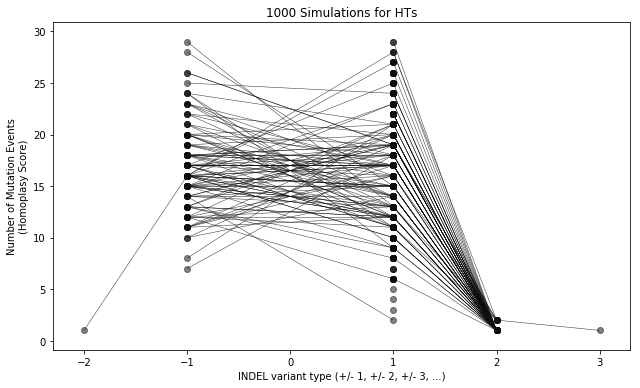

In [6]:
fig, ax = plt.subplots()
for sim_i in HT_homoplasy_score_series_per_run.keys():

    plt.plot(HT_homoplasy_score_series_per_run[sim_i].index, HT_homoplasy_score_series_per_run[sim_i].values, color = '0.05', alpha = 0.85, linewidth = 0.5)
    plt.scatter(HT_homoplasy_score_series_per_run[sim_i].index, HT_homoplasy_score_series_per_run[sim_i].values, color = '0.05', alpha = 0.5)

plt.ylabel('Number of Mutation Events\n(Homoplasy Score)')
plt.xlabel('INDEL variant type (+/- 1, +/- 2, +/- 3, ...)')
plt.title('1000 Simulations for HTs')
#ax.set_yscale('log')
fig = plt.gcf()
fig.set_size_inches(9.0, 5.5)
fig.tight_layout()
plt.show()

## Count the number of *frameshift* mutations that occurred in each simulation

In [7]:
frameshift_homomplasy_score_across_sims = []

for sim_i in HT_homoplasy_score_series_per_run.keys():
    
    frameshift_homoplasy_score_sim_i = 0
    
    homoplasy_score_per_mut_sim_i =  HT_homoplasy_score_series_per_run[sim_i]
    
    # iterate through each genotype and check if it is a frameshift, if frameshift add to homoplasy score
    for indel_genotype in HT_homoplasy_score_series_per_run[sim_i].keys():
        
        if float(indel_genotype) / 3.0 != 0: # if not divisible by 3, then frameshift
            frameshift_homoplasy_score_sim_i += homoplasy_score_per_mut_sim_i[indel_genotype]
    
    # store number of frameshifts for this sim in list
    frameshift_homomplasy_score_across_sims.append(frameshift_homoplasy_score_sim_i)

In [8]:
np.mean(frameshift_homomplasy_score_across_sims)

17.818

In [9]:
np.median(frameshift_homomplasy_score_across_sims)

16.0

#### Plot Homoplasy Score distribution from each simulation

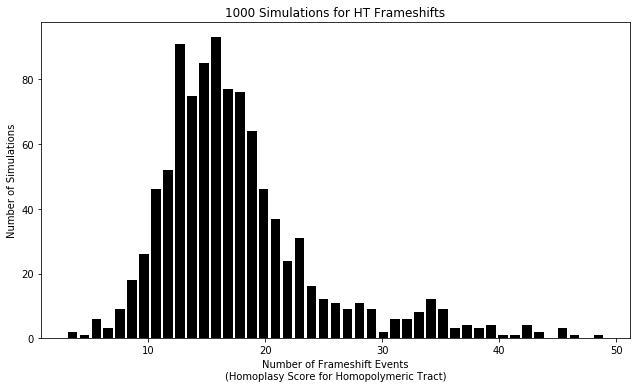

In [10]:
fig, ax = plt.subplots()

ax.hist(frameshift_homomplasy_score_across_sims, bins = 45, rwidth = 0.8, color = 'k')

plt.xlabel('Number of Frameshift Events\n(Homoplasy Score for Homopolymeric Tract)')
plt.ylabel('Number of Simulations')
plt.title('1000 Simulations for HT Frameshifts')
#ax.set_yscale('log')
fig = plt.gcf()
fig.set_size_inches(9.0, 5.5)
fig.tight_layout()
plt.show()

In [20]:
np.percentile(np.array(frameshift_homomplasy_score_across_sims), 99.8)

45.00199999999995

## Count the number of *INDEL* mutations that occurred in each simulation

In [12]:
INDEL_homomplasy_score_across_sims = []

for sim_i in HT_homoplasy_score_series_per_run.keys():
    
    INDEL_homoplasy_score_sim_i = 0
    
    homoplasy_score_per_mut_sim_i =  HT_homoplasy_score_series_per_run[sim_i]
    
    # iterate through each genotype and check if it is a frameshift, if frameshift add to homoplasy score
    for indel_genotype in HT_homoplasy_score_series_per_run[sim_i].keys():
        
        INDEL_homoplasy_score_sim_i += homoplasy_score_per_mut_sim_i[indel_genotype]
    
    # store number of INDELs for this sim in list
    INDEL_homomplasy_score_across_sims.append(INDEL_homoplasy_score_sim_i)

In [13]:
np.mean(INDEL_homomplasy_score_across_sims)

17.818

In [14]:
np.median(INDEL_homomplasy_score_across_sims)

16.0

#### Plot Homoplasy Score distribution from each simulation

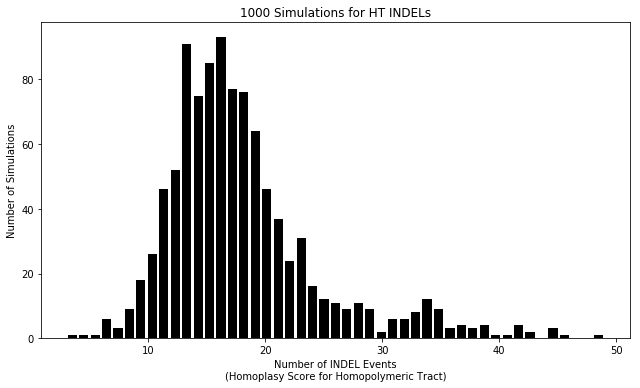

In [18]:
fig, ax = plt.subplots()

ax.hist(INDEL_homomplasy_score_across_sims, bins = 47, rwidth = 0.8, color = 'k')

plt.xlabel('Number of INDEL Events\n(Homoplasy Score for Homopolymeric Tract)')
plt.ylabel('Number of Simulations')
plt.title('1000 Simulations for HT INDELs')
#ax.set_yscale('log')
fig = plt.gcf()
fig.set_size_inches(9.0, 5.5)
fig.tight_layout()
plt.show()

In [21]:
np.percentile(np.array(INDEL_homomplasy_score_across_sims), 99.8)

45.00199999999995

In [24]:
np.percentile(np.array(INDEL_homomplasy_score_across_sims), 95)

241.0

### Plot the number of mutation events for each INDEL genotype across simulations

In [34]:
# collect all unique INDEL genotypes
unique_INDEL_genotypes = []
for sim_i in HT_homoplasy_score_series_per_run.keys():
    unique_INDEL_genotypes = unique_INDEL_genotypes + list(HT_homoplasy_score_series_per_run[sim_i].keys())
unique_INDEL_genotypes = list(set(unique_INDEL_genotypes))

unique_INDEL_genotypes = np.sort(np.array(unique_INDEL_genotypes)) #unique variant genotypes (+/-1, +/-2, +/-3, ...) appearing in this simulation
unique_INDEL_genotypes = unique_INDEL_genotypes[unique_INDEL_genotypes != 0]

In [35]:
unique_INDEL_genotypes

array([-3, -2, -1,  1,  2,  3,  4])

In [ ]:
num_mutation_events_per_genotype_dict = {}
#create an empty list 

# iterate through each indel genotype
for x in unique_INDEL_genotypes:

    num_mutation_events_for_each_sim = []
    
    # iterate through each simulation
    for sim_i in frameshift_homomplasy_score_across_sims.keys():
    
        proportion_homoplasy_scores_greater_than_x_for_each_sim.append(float((homoplasy_score_distribution_per_run[sim_i][homoplasy_score_distribution_per_run[sim_i].index >= x].sum())) / float((homoplasy_score_distribution_per_run[sim_i].sum())))
        
    proportion_greater_than_x_dict[x] = proportion_homoplasy_scores_greater_than_x_for_each_sim 

### *Functions* for Boxplot

In [36]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 1.5

# function for setting the colors of the box plots pairs
def setBoxColors(bp , color):
    setp(bp['boxes'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['fliers'][0], color=color)
    setp(bp['medians'][0], color='k' , linewidth = 1.5)
    bp['fliers'][0].set_markerfacecolor('black')
    bp['fliers'][0].set_markeredgewidth(0.35)
    bp['fliers'][0].set_markersize(3.65)
    bp['fliers'][0].set_markeredgecolor('white')
    bp['fliers'][0].set_alpha(0.85)
    
def plot_muts_frameshift_homoplasy_score(sim_values, x_pos, ax):
    
    #make boxplot
    bp = ax.boxplot(sim_values , positions = [ind[x_pos]], widths = box_width)
    setBoxColors(bp , 'k')
    
    return round(np.median(sim_values), 4)

/home/rv76/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


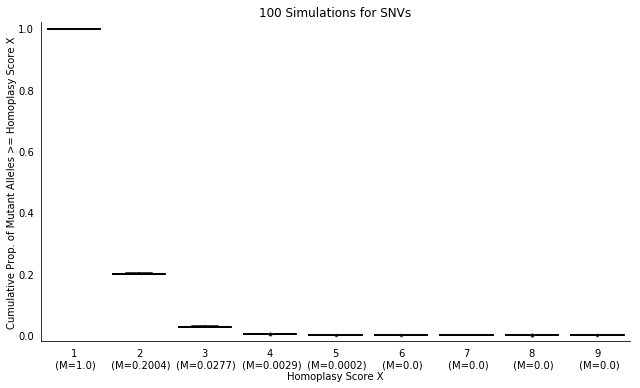

In [8]:
fig , ax = plt.subplots()
box_width = 0.8
ind = np.arange(1, 10)

#bottom plot
median_props = []
x_pos = 0
for homoplasy_score_i in ind:

    #plot boxplot for lineage & store the number of isolates in sample
    median_prop_i = plot_prop_muts_GE_homoplasy_score(proportion_greater_than_x_dict[homoplasy_score_i] , x_pos, ax)
    median_props.append(median_prop_i)
    x_pos += 1

ax.set_xlim(0.5 , 9.5) #x-axis
ax.set_ylim(-0.02 , 1.02) #y-axis
#ax.set_yscale('log')

ax.set_xticks(ind)
ax.set_xticklabels([], rotation='horizontal', fontsize = 10)
x_labels = [str(homoplasy_score_i) + '\n (M=' + str(med_prop) + ')' for homoplasy_score_i,med_prop in zip(ind,median_props)]
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 10)
ax.grid(False)
ax.set_ylabel('Cumulative Prop. of Mutant Alleles >= Homoplasy Score X', fontsize = 10, color = 'k', labelpad = 1)
ax.set_xlabel('Homoplasy Score X', fontsize = 10, color = 'k', labelpad = 1)
ax.set_title('100 Simulations for SNVs')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax.tick_params(colors = 'k', which = 'both')

fig = plt.gcf()
fig.set_size_inches(9.0, 5.5)
fig.tight_layout()
plt.show()